In [1]:
import os
%pylab inline
import numpy as np
import hashlib

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os 
import hashlib
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Softmax
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

2024-09-18 13:14:31.826361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 13:14:31.922415: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-18 13:14:31.922435: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-18 13:14:32.386431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

### Compare with scan Notebooks 

In [20]:
checkpoint_dir_th = '../checkpoints/MF'
fidelity_mf = np.load(os.path.join(checkpoint_dir_th, '_MF_scan_window_size_and_location_window_size_0_770.npz'))
fidelity_mf = fidelity_mf['fidelity']
fidelity_mf[fidelity_mf == -1] = np.nan

In [21]:
checkpoint_dir_th = '../checkpoints/TH'
fidelity_th = np.load(os.path.join(checkpoint_dir_th, '_TH_scan_window_size_and_location_window_size_0_770.npz'))
fidelity_th = fidelity_th['fidelity']
fidelity_th[fidelity_th == -1] = np.nan

In [22]:
checkpoint_dir8 = '../checkpoints/scan_window_location_and_size_h8'
data1 = np.load(os.path.join(checkpoint_dir8, '_2-layer_h-8_scan_window_size_and_location_window_size_0_350.npz'))
fidelity_nn8 = data1['fidelity']
fidelity_nn8[fidelity_nn8 == -1] = np.nan

In [23]:
checkpoint_dir14 = '../checkpoints/scan_window_location_and_size_h14'
data1 = np.load(os.path.join(checkpoint_dir14, '_2-layer_scan_window_size_and_location.npz'))
data2 = np.load(os.path.join(checkpoint_dir14, '_2-layer_scan_window_size_and_location_450_700.npz'))
data3 = np.load(os.path.join(checkpoint_dir14, '_2-layer_scan_window_size_and_location_window_size_770.npz'))
fidelity_nn14 = np.concatenate((data1['fidelity'], data2['fidelity'], data3['fidelity']), 0)
fidelity_nn14[fidelity_nn14 == -1] = np.nan

In [24]:
checkpoint_dir64 = '../checkpoints/scan_window_location_and_size_h64/'
fidelity_nn64 = np.load(os.path.join(checkpoint_dir64, '_2-layer_scan_window_size_and_location_window_size_0_770.npz'))
fidelity_nn64 = fidelity_nn64['fidelity']
fidelity_nn64[fidelity_nn64 == -1] = np.nan

In [25]:
readout_loc_list = list(range(0, 351, 50))
readout_loc_list

[0, 50, 100, 150, 200, 250, 300, 350]

Text(0, 0.5, 'Fidelity')

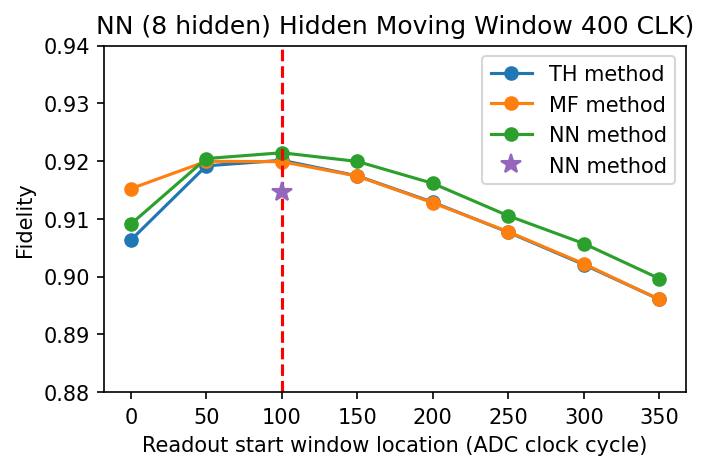

In [26]:
idx = 7

figure(figsize = (5,3), dpi = 150)
# figure(figsize = (4,3), dpi = 150)
# plot(readout_loc_list, all_fidelity_train, 'o', color = 'C0',label = 'TH method_Train')
plot(readout_loc_list, fidelity_th[idx], 'o-', color = 'C0', label = 'TH method')
# plot(readout_loc_list, all_fidelity_MF_train, 'o', color = 'C1', label = 'MF method_Train')
plot(readout_loc_list, fidelity_mf[idx], 'o-', color = 'C1', label = 'MF method')
# plot(readout_loc_list, np.array(ml_accuracy)*2-1, 'o-', color = 'C2', label = 'Large NN method')
# plot(readout_loc_list, fidelity_nn64[idx], 'o-', color = 'C4', label = 'NN (64>2) method_Test')
plot(readout_loc_list, fidelity_nn8.reshape(-1), 'o-', color = 'C2', label = 'NN method')
axvline(100, ls = '--', color = 'red')
plot([100], [0.91462], '*', color = 'C4', markersize=10, label = 'NN method')
# plot([100], [0.91462], '*', color = 'C7', label = 'NN method (not optimized)')

plt.title('NN (8 hidden) Hidden Moving Window 400 CLK)')

legend(loc = 'upper right')
# legend(loc = (1.1,.3))
ylim(0.88,0.94)
xlabel('Readout start window location (ADC clock cycle)')
ylabel('Fidelity')

In [9]:
print(fidelity_th[idx])
print(fidelity_mf[idx])
print(fidelity_nn64[idx])
print(fidelity_nn14[idx])

[0.90632 0.91918 0.92014 0.91744 0.91288 0.90768 0.90208 0.89606]
[0.91522 0.91996 0.9199  0.9174  0.91278 0.90776 0.90222 0.89604]
[0.91226 0.91806 0.91874 0.91858 0.91536 0.91012 0.90444 0.89814]
[0.91294 0.91716 0.91952 0.91858 0.9151  0.90884 0.90402 0.89776]


Text(0, 0.5, 'Flidelity')

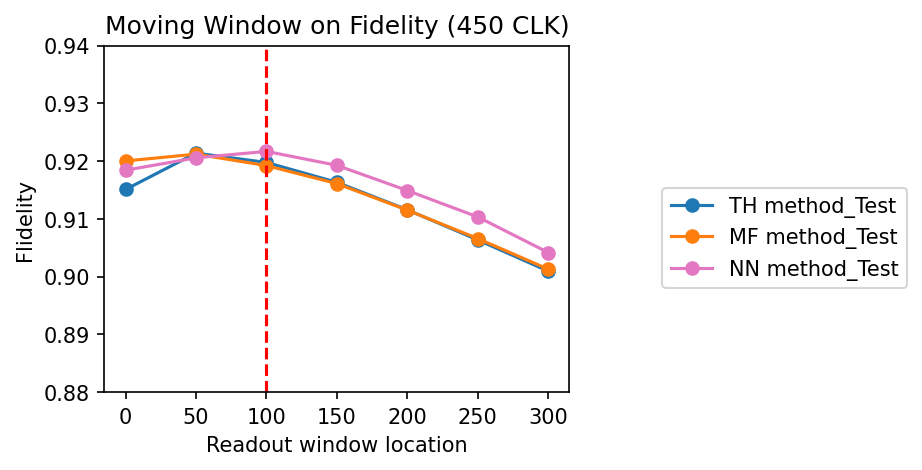

In [10]:
idx = 8

figure(figsize = (4,3), dpi = 150)
# plot(readout_loc_list, all_fidelity_train, 'o', color = 'C0',label = 'TH method_Train')
plot(readout_loc_list, fidelity_th[idx], 'o-', color = 'C0', label = 'TH method_Test')
# plot(readout_loc_list, all_fidelity_MF_train, 'o', color = 'C1', label = 'MF method_Train')
plot(readout_loc_list, fidelity_mf[idx], 'o-', color = 'C1', label = 'MF method_Test')
# plot(readout_loc_list, np.array(ml_accuracy)*2-1, 'o-', color = 'C2', label = 'Large NN method')
# plot(readout_loc_list, fidelity_nn64[idx], 'o-', color = 'C4', label = 'NN (64>2) method_Test')
plot(readout_loc_list, fidelity_nn14[idx], 'o-', color = 'C6', label = 'NN method_Test')

plt.title('Moving Window on Fidelity (450 CLK)')

axvline(100, ls = '--', color = 'red')
legend(loc = (1.2,.3))
ylim(0.88,0.94)
xlabel('Readout window location')
ylabel('Flidelity')

### Fidelity vs Window Size 

In [11]:
import os 
import pickle
import hashlib

import hls4ml 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/data/jcampos/projects/ml-quantum-readout/environment/hls4ml/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [12]:
def get_model(input_shape, hidden=14):
    model = Sequential()
    model.add(QDense(
        hidden, 
        activation='relu', 
        name='fc1',
        input_shape=(input_shape,), 
        kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1)
    ))
    model.add(QBatchNormalization(
            name='batchnorm1',
            gamma_quantizer=quantized_bits(6, 0, 1),
            mean_quantizer=quantized_bits(6, 0, 1),
            variance_quantizer=quantized_bits(6, 0, 1),
            beta_quantizer=quantized_bits(6, 0, 1),
    ))
    model.add(
        QDense(2, name='fc2', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1))
    )
    return model


window_sizes = list(range(50, 651, 50))
parameters14 = list()
parameters64 = list()
for window_size in window_sizes:
    model = get_model(window_size*2, hidden=14)
    parameters14.append(model.count_params())
    model = get_model(window_size*2, hidden=64)
    parameters64.append(model.count_params())

2024-09-18 01:03:47.004379: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-09-18 01:03:47.004421: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-18 01:03:47.004451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator4.fnal.gov): /proc/driver/nvidia/version does not exist
2024-09-18 01:03:47.004759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Text(0, 0.5, 'Fidelity')

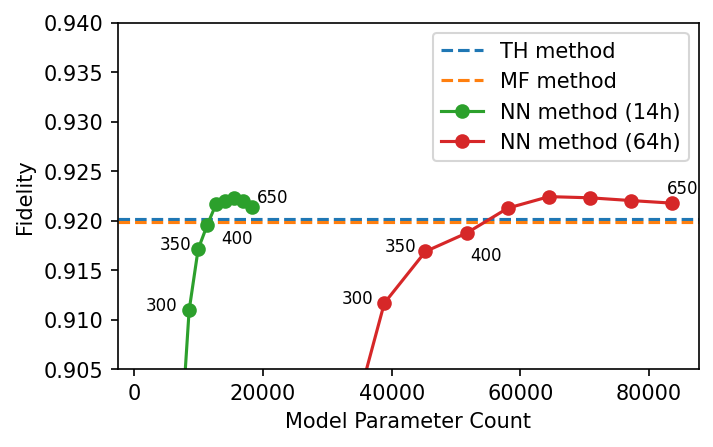

In [106]:
fidelity_nn14

idx = 7 # 400 window size 
jdx = 2 # 100 start location 

plt.figure(figsize = (5,3), dpi = 150)
# plot(parameters14, fidelity_th[:,jdx][:-2], 'o-', color = 'C0', label = 'TH method')
# plot(parameters14, fidelity_mf[:,jdx][:-2], 'o-', color = 'C1', label = 'MF method')
plt.axhline(fidelity_th[idx,jdx], linestyle='--', color='C0', label='TH method')
plt.axhline(fidelity_mf[idx,jdx], linestyle='--', color='C1', label='MF method')
plt.plot(parameters14, fidelity_nn14[:,jdx][:-2], 'o-', color = 'C2', label = 'NN method (14h)')
plt.plot(parameters64, fidelity_nn64[:,jdx][:-2], 'o-', color = 'C3', label = 'NN method (64h)')

fid = fidelity_nn14[:,jdx][:-2]

idx = 5
params = parameters14[idx] - (parameters14[idx]*0.8)
acc = fid[idx] #+ (fid[idx]*0.01)
plt.annotate(f'{window_sizes[idx]}', (params, acc), size=8)

idx = 6
params = parameters14[idx] - (parameters14[idx]*0.6)
acc = fid[idx] #+ (fid[idx]*0.01)
plt.annotate(f'{window_sizes[idx]}', (params, acc), size=8)

idx = 7
params = parameters14[idx] + (parameters14[idx]*0.2)
acc = fid[idx] - (fid[idx]*0.002)
plt.annotate(f'{window_sizes[idx]}', (params, acc), size=8)

idx = -1
params = parameters14[idx] + (parameters14[idx]*0.04)
acc = fid[idx] + (fid[idx]*0.0005)
plt.annotate(f'{window_sizes[idx]}', (params, acc), size=8)


fid = fidelity_nn64[:,jdx][:-2]

idx = 5
params = parameters64[idx] - (parameters64[idx]*0.17)
acc = fid[idx] #+ (fid[idx]*0.01)
plt.annotate(f'{window_sizes[idx]}', (params, acc), size=8)

idx = 6
params = parameters64[idx] - (parameters64[idx]*0.14)
acc = fid[idx] #+ (fid[idx]*0.01)
plt.annotate(f'{window_sizes[idx]}', (params, acc), size=8)

idx = 7
params = parameters64[idx] + (parameters64[idx]*0.01)
acc = fid[idx] - (fid[idx]*0.003)
plt.annotate(f'{window_sizes[idx]}', (params, acc), size=8)

idx = -1
params = parameters64[idx] - (parameters64[idx]*0.01)
acc = fid[idx] + (fid[idx]*0.001)
plt.annotate(f'{window_sizes[idx]}', (params, acc), size=8)

# fid = fidelity_nn14[:,jdx][:-2]
# acc_shift = 0.002
# param_shift = 0.1

# for idx in range(1, len(window_sizes), 2):
#     acc = fid[idx] + (fid[idx]*acc_shift)
#     params = parameters14[idx] - (parameters14[idx]*param_shift)
#     print(idx, window_sizes[idx], acc, params)
#     if idx == 5:
#         acc = fid[idx] + (fid[idx]*0.003)
#         params = parameters14[idx] - (parameters14[idx]*0.15)
#         plt.annotate(f'{window_sizes[idx]}', (params, acc), size=8)
#     elif idx > 5:
#         acc = fid[idx] + (fid[idx]*0.003)
#         params = parameters14[idx] - (parameters14[idx]*0.01)
#         plt.annotate(f'{window_sizes[idx]}', (params, acc), size=8)
#     else:
#         plt.annotate(f'{window_sizes[idx]}', (params, acc), size=8)
#     # plt.annotate(single_window_size[idx], (acc, params))


plt.legend()
# legend(loc = (1.2,.3))

plt.ylim(0.905,0.94)
# xlim(5e3,19e3)

plt.xlabel('Model Parameter Count')
ylabel('Fidelity')